C:\Users\rlatm\AppData\Local\Temp\ipykernel_35052\2426286591.py:44: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start)
[*********************100%***********************]  1 of 1 completed


Data Prepared. Shape: (1435, 17)
Price            Close        RSI       MACD      Target
Date                                                    
2025-11-19  403.989990  39.915097  -7.169248  395.230011
2025-11-20  395.230011  32.101801  -8.707118  391.089996
2025-11-21  391.089996  26.390087 -10.143033  417.779999
2025-11-24  417.779999  42.035612  -9.023331  419.399994
2025-11-25  419.399994  35.781409  -7.914011  426.579987

Train Set: (1148, 15), Test Set: (287, 15)

[1] Training Baseline: Linear Regression...
   -> Linear Regression RMSE: 13.7109, R2: 0.9597

[2] Tuning SVR (Support Vector Regression)...
   -> Best SVR Params: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

[3] Tuning XGBoost...
   -> Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

[4] Building Ensemble Model (Voting Regressor)...
   -> Ensemble RMSE: 23.1820, R2: 0.8848

[5] Training Deep Learning Model (LSTM)...


C:\Users\rlatm\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
   -> LSTM RMSE: 27.8423, R2: 0.8339


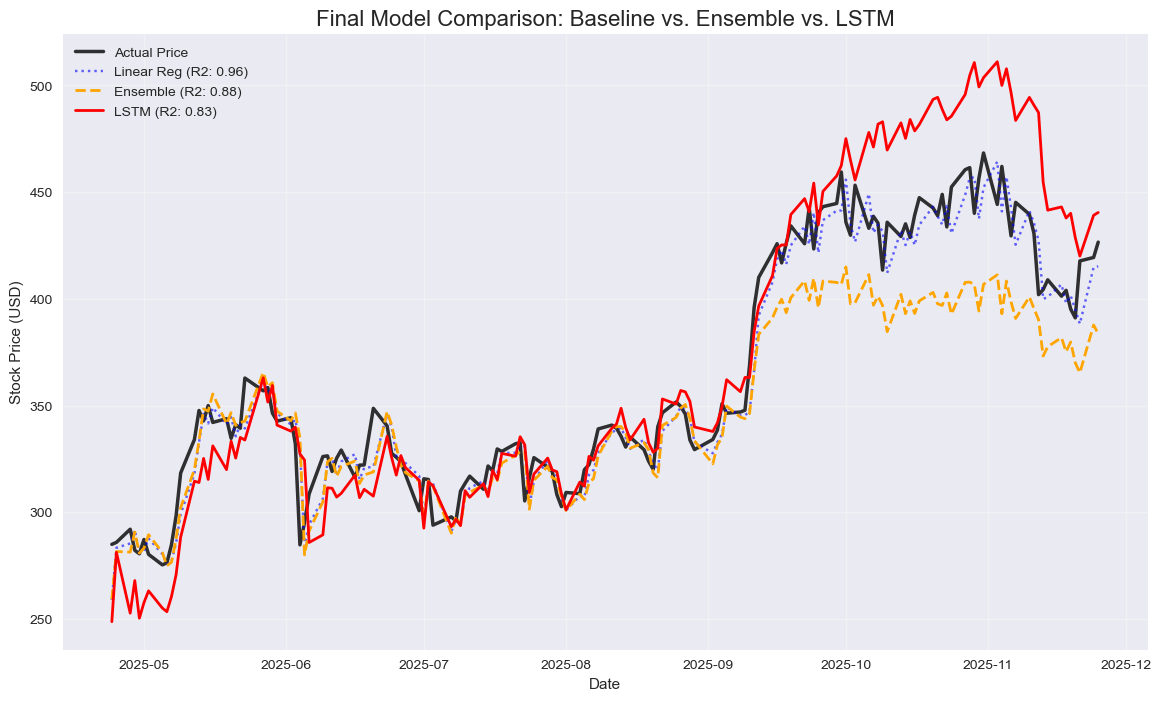


🚀 PREDICTION FOR THE NEXT TRADING DAY
Based on data from: 2025-11-25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1. Linear Regression : $415.24
2. Voting Ensemble   : $383.66
3. LSTM (Deep Learning): $440.48
--------------------------------------------------
👉 Conclusion: Based on the highest R2 Score (0.9597),
   The most reliable prediction is by [Linear Regression]: $415.24


In [2]:
# ==============================================================================
# Project: Tesla Stock Price Prediction using Machine Learning & Deep Learning
# ==============================================================================
# Objectives:
# 1. Feature Engineering using Financial Indicators (RSI, MACD, etc.)
# 2. Model Comparison: Linear Regression (Baseline) vs. Advanced Models (SVR, XGBoost)
# 3. Optimization: Hyperparameter Tuning using GridSearchCV
# 4. Ensemble Learning: Voting Regressor
# 5. Deep Learning: LSTM Network
# ==============================================================================

import os
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Visualization Settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ==============================================================================
# Step 1: Data Collection & Advanced Feature Engineering
# ==============================================================================
def prepare_data(ticker='TSLA', start='2020-01-01'):
    print(f"Downloading data for {ticker}...")
    df = yf.download(ticker, start=start)
    
    # Flatten MultiIndex columns if necessary
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    # Create a copy to avoid SettingWithCopy warnings
    df = df.copy()

    # 1. Moving Averages (Trend Indicators)
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    # 2. RSI (Relative Strength Index) - Momentum Indicator
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # 3. MACD (Moving Average Convergence Divergence)
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # 4. Bollinger Bands (Volatility Indicator)
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    std_dev = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (2 * std_dev)
    df['BB_Lower'] = df['BB_Middle'] - (2 * std_dev)
    
    # 5. Volatility & Lag Features
    df['Daily_Return'] = df['Close'].pct_change()
    df['Lag_1'] = df['Close'].shift(1)
    df['Lag_2'] = df['Close'].shift(2)

    # 6. Target Generation (Predict Next Day's Close Price)
    df['Target'] = df['Close'].shift(-1)

    # Drop NaNs created by indicators and shifting
    df.dropna(inplace=True)
    
    return df

# Load and Prepare Data
df = prepare_data()
print(f"Data Prepared. Shape: {df.shape}")
print(df[['Close', 'RSI', 'MACD', 'Target']].tail())

# ==============================================================================
# Step 2: Data Splitting & Scaling
# ==============================================================================
# Define features to be used for prediction
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 
                'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 
                'BB_Upper', 'BB_Lower', 'Daily_Return', 'Lag_1', 'Lag_2']

X = df[feature_cols]
y = df['Target']

# Time Series Split (No Shuffling to preserve order)
# Last 20% of data is used for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardization (Important for SVR, LSTM, and Linear Models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTrain Set: {X_train_scaled.shape}, Test Set: {X_test_scaled.shape}")

# ==============================================================================
# Step 3: Modeling & Hyperparameter Tuning (Grid Search)
# ==============================================================================
# We use TimeSeriesSplit for Cross-Validation
tscv = TimeSeriesSplit(n_splits=3)

# 3.1. Linear Regression (Baseline)
print("\n[1] Training Baseline: Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
print(f"   -> Linear Regression RMSE: {rmse_lr:.4f}, R2: {r2_lr:.4f}")

# 3.2. Tuning SVR (Support Vector Regression)
print("\n[2] Tuning SVR (Support Vector Regression)...")
param_grid_svr = {
    'C': [10, 100],
    'gamma': ['scale', 0.01],
    'kernel': ['rbf']
}
grid_svr = GridSearchCV(SVR(), param_grid_svr, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_svr.fit(X_train_scaled, y_train)
best_svr = grid_svr.best_estimator_
print(f"   -> Best SVR Params: {grid_svr.best_params_}")

# 3.3. Tuning XGBoost (Gradient Boosting)
print("\n[3] Tuning XGBoost...")
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
grid_xgb = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42), 
                        param_grid_xgb, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_xgb.fit(X_train_scaled, y_train)
best_xgb = grid_xgb.best_estimator_
print(f"   -> Best XGBoost Params: {grid_xgb.best_params_}")

# ==============================================================================
# Step 4: Ensemble Learning (Voting Regressor)
# ==============================================================================
print("\n[4] Building Ensemble Model (Voting Regressor)...")
# Combining Linear (Trend) + SVR (Pattern) + XGBoost (Tree-based)
ensemble_models = [
    ('lr', lr_model),
    ('svr', best_svr),
    ('xgb', best_xgb)
]
voting_model = VotingRegressor(estimators=ensemble_models)
voting_model.fit(X_train_scaled, y_train)

y_pred_voting = voting_model.predict(X_test_scaled)
rmse_voting = np.sqrt(mean_squared_error(y_test, y_pred_voting))
r2_voting = r2_score(y_test, y_pred_voting)
print(f"   -> Ensemble RMSE: {rmse_voting:.4f}, R2: {r2_voting:.4f}")

# ==============================================================================
# Step 5: Deep Learning (LSTM) - Outside Scope Algorithm
# ==============================================================================
print("\n[5] Training Deep Learning Model (LSTM)...")

# Reshape data for LSTM [Samples, Time Steps, Features]
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build LSTM Architecture
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(1, X_train_scaled.shape[1]), return_sequences=False))
lstm_model.add(Dropout(0.2)) # Prevent overfitting
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train LSTM
history = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=16, verbose=0, shuffle=False)

# Predict
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Evaluate LSTM
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
r2_lstm = r2_score(y_test, y_pred_lstm)
print(f"   -> LSTM RMSE: {rmse_lstm:.4f}, R2: {r2_lstm:.4f}")

# ==============================================================================
# Step 6: Final Visualization & Conclusion
# ==============================================================================
plt.figure(figsize=(14, 8))
days_plot = 150 # Zoom in on the last 150 days

# Actual Price
plt.plot(y_test.index[-days_plot:], y_test.values[-days_plot:], 
         label='Actual Price', color='black', linewidth=2.5, alpha=0.8)

# Baseline
plt.plot(y_test.index[-days_plot:], y_pred_lr[-days_plot:], 
         label=f'Linear Reg (R2: {r2_lr:.2f})', color='blue', linestyle=':', alpha=0.6)

# Ensemble
plt.plot(y_test.index[-days_plot:], y_pred_voting[-days_plot:], 
         label=f'Ensemble (R2: {r2_voting:.2f})', color='orange', linestyle='--', linewidth=2)

# Deep Learning
plt.plot(y_test.index[-days_plot:], y_pred_lstm[-days_plot:], 
         label=f'LSTM (R2: {r2_lstm:.2f})', color='red', linestyle='-', linewidth=2)

plt.title('Final Model Comparison: Baseline vs. Ensemble vs. LSTM', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==============================================================================
# Step 7: Predict Tomorrow's Price (Fixed Version)
# ==============================================================================
print("\n" + "="*50)
print("🚀 PREDICTION FOR THE NEXT TRADING DAY")
print("="*50)

# Get latest data features
latest_data = df[feature_cols].iloc[[-1]]
print(f"Based on data from: {latest_data.index[0].date()}")

# Preprocess
latest_scaled = scaler.transform(latest_data)
latest_lstm = latest_scaled.reshape((1, 1, latest_scaled.shape[1]))

# Predict
pred_next_lr = lr_model.predict(latest_scaled)[0]
pred_next_ensemble = voting_model.predict(latest_scaled)[0]
pred_next_lstm = lstm_model.predict(latest_lstm).flatten()[0]

print(f"1. Linear Regression : ${pred_next_lr:.2f}")
print(f"2. Voting Ensemble   : ${pred_next_ensemble:.2f}")
print(f"3. LSTM (Deep Learning): ${pred_next_lstm:.2f}")
print("-" * 50)

# Final selection logic (Simplified to avoid eval error)
scores = {'Linear Regression': r2_lr, 'Ensemble': r2_voting, 'LSTM': r2_lstm}
best_model_name = max(scores, key=scores.get)

if best_model_name == 'Linear Regression':
    best_price = pred_next_lr
elif best_model_name == 'Ensemble':
    best_price = pred_next_ensemble
else:
    best_price = pred_next_lstm

print(f"👉 Conclusion: Based on the highest R2 Score ({max(scores.values()):.4f}),")
print(f"   The most reliable prediction is by [{best_model_name}]: ${best_price:.2f}")

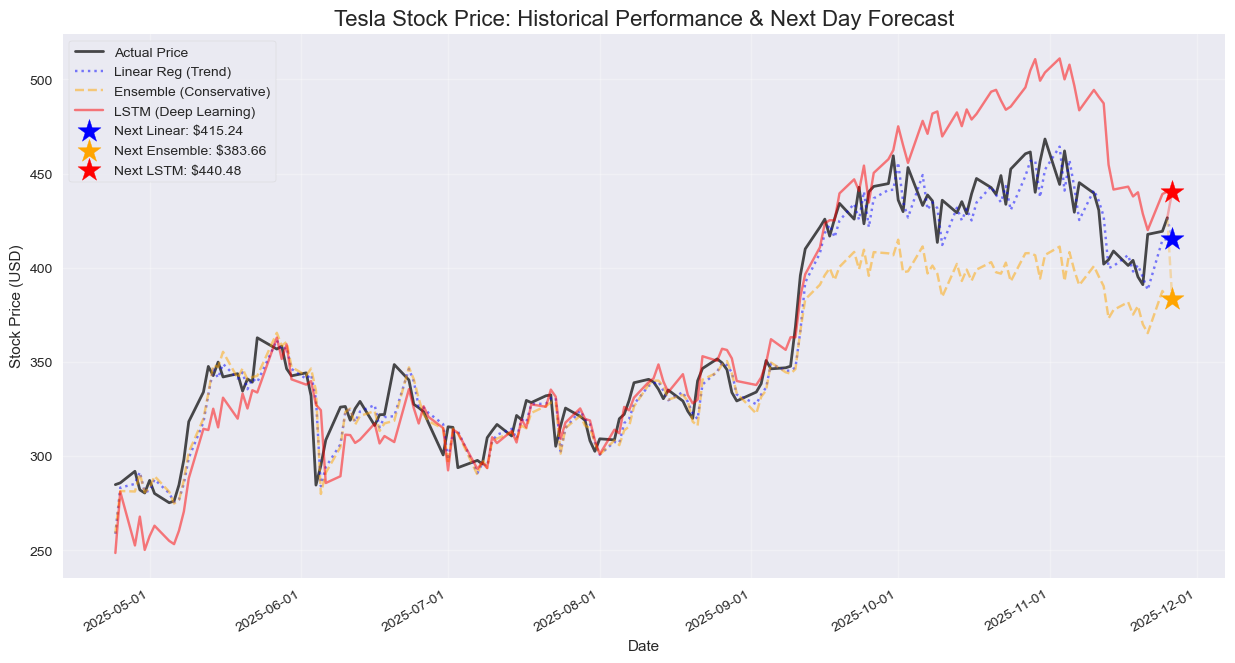

In [3]:
# ==============================================================================
# Step 8: Comprehensive Visualization (History + Future Forecast)
# ==============================================================================
import matplotlib.dates as mdates
from datetime import timedelta

# 1. Prepare Data for Plotting
days_plot = 150
last_date = df.index[-1]
next_date = last_date + timedelta(days=1) # The next trading day (approx)

# Historical Data (Last 150 days)
dates_history = df.index[-days_plot:]
actual_history = y[-days_plot:].values

# Model Predictions on History (Test Set portions)
# Note: We need to slice the predictions to match the 'dates_history'
# We assume the test set covers at least the last 150 days.
pred_lr_history = y_pred_lr[-days_plot:]
pred_ens_history = y_pred_voting[-days_plot:]
pred_lstm_history = y_pred_lstm[-days_plot:]

# 2. Plotting
plt.figure(figsize=(15, 8))

# (1) Actual Price History
plt.plot(dates_history, actual_history, label='Actual Price', color='black', linewidth=2, alpha=0.7)

# (2) Historical Predictions (lines)
plt.plot(dates_history, pred_lr_history, label='Linear Reg (Trend)', color='blue', linestyle=':', alpha=0.5)
plt.plot(dates_history, pred_ens_history, label='Ensemble (Conservative)', color='orange', linestyle='--', alpha=0.5)
plt.plot(dates_history, pred_lstm_history, label='LSTM (Deep Learning)', color='red', linestyle='-', alpha=0.5)

# (3) Future Predictions (Dots)
# Plotting the single future point for each model
plt.scatter([next_date], [pred_next_lr], color='blue', marker='*', s=300, label=f'Next Linear: ${pred_next_lr:.2f}', zorder=5)
plt.scatter([next_date], [pred_next_ensemble], color='orange', marker='*', s=300, label=f'Next Ensemble: ${pred_next_ensemble:.2f}', zorder=5)
plt.scatter([next_date], [pred_next_lstm], color='red', marker='*', s=300, label=f'Next LSTM: ${pred_next_lstm:.2f}', zorder=5)

# Connecting lines from last actual data to future prediction (Visual Aid)
plt.plot([last_date, next_date], [actual_history[-1], pred_next_lr], color='blue', linestyle=':', alpha=0.3)
plt.plot([last_date, next_date], [actual_history[-1], pred_next_ensemble], color='orange', linestyle='--', alpha=0.3)
plt.plot([last_date, next_date], [actual_history[-1], pred_next_lstm], color='red', linestyle='-', alpha=0.3)

# Formatting
plt.title('Tesla Stock Price: Historical Performance & Next Day Forecast', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend(loc='upper left', frameon=True)
plt.grid(True, alpha=0.3)

# Date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.show()